In [8]:
#A package with 4 funcitons, get_cd, smooth_cd, irradiance, and updated_numberdensity which return plots of the column density as a function of tangent heigh both smoothed and not, irradiance as a function of time and number density as a function of tangent height.

#Commented out print statements are there for testing purposes, the same is true for the commented out get_cd function call.

import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from astropy.convolution import convolve, convolve_fft, Box1DKernel
from matplotlib.dates import DateFormatter
from scipy import interpolate
import scipy.io
from scipy.io import readsav
import netCDF4 as nc
import julian
import datetime
import os
from os.path import dirname, join as pjoin
import csv
from pathlib import Path

In [9]:
occultation_data = Path.cwd() / 'stellar-occultations'
cross_section = Path.cwd() / "o2_cross_section.ncdf"
#print(occultation_data)
#print(cross_section)



In [10]:
files = list(occultation_data.glob('**/*.nc'))

#print(files[0])

file_handle = nc.Dataset(Path.cwd() / "o2_cross_section.ncdf", mode='r')

#print(file_handle)

In [11]:
sigma = np.squeeze(file_handle.variables['sigma'])
wave = np.squeeze(file_handle.variables['wave'])
#print('shape of sigma array', np.asarray(sigma).shape)
#print('shape of wave array', np.asarray(wave).shape)
#print('type wave', type(np.array(wave.tolist())))
new_wave = np.array(wave.tolist())
#print(len(new_wave))
#print('type sigma', type(sigma))
#print(len(sigma))
#plt.plot(new_wave, sigma)

In [12]:
# get column density function
def get_cd(file):
    ds = nc.Dataset(file)
    irradiance = ds.variables['irradiance'][:]
    tan_ht = ds.variables['tanht'][:]
    wavelength = ds.variables['wavelength'][:]
    mjd = ds.variables['julian_date'][:]
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    wavelength_i = np.where(wavelength > 115)
    wavelength_1 = wavelength[wavelength_i]
    irradiance_1 = irradiance[wavelength_i]
    tan_ht_1 = tan_ht[wavelength_i]
    dt = []
    for i in mjd:
        date_time = julian.from_jd(i, fmt='jd')
        dt.append(date_time)
    wavelength_1_ave = np.mean(wavelength_1)
    f =  interpolate.interp1d(new_wave, sigma)
    new_sigma = f(wavelength_1_ave)
    tanht_top = np.where((tan_ht > 240) & (tan_ht < 260))
    places_to_ave_irr = irradiance_1[tanht_top]
    ave_irradiance = np.mean(places_to_ave_irr)
    ratio = irradiance_1/ave_irradiance
    smoothed_ratio = convolve(ratio, Box1DKernel(5))
    smoothed_ratio[smoothed_ratio < 0] = 0.01
    plt.figure()
    plt.plot(smoothed_ratio, tan_ht_1)
    plt.ylim(0, 291)
    plt.xlabel('Extinction Ratio')
    plt.ylabel('Tangent Height (km)')
    plt.title('Extinction Ratio')
    column_density = -np.log(smoothed_ratio)/new_sigma
    cd_i = np.where(tan_ht_1 < 210)
    column_density = column_density[cd_i]
    tan_ht_1 = tan_ht_1[cd_i]
    plt.figure()
    plt.plot(column_density, tan_ht_1 + 6371, label="Column Density")
    plt.ylim(6475, 6625)
    plt.xscale('log')
    plt.xlabel('Column Density (cm-2)')
    plt.ylabel('Tangent Height (km)')
    plt.title('Column Density Vs. Tangent Height')
    plt.savefig("C:\\Users\\ameli\\OneDrive\\Desktop" + os.path.basename(file) + ".png")
    return column_density, tan_ht_1, max(dt)

(array([3.51157276e+15, 4.96451909e+15, 4.85172406e+15, 7.19913079e+15,
        8.31280315e+15, 8.19464556e+15, 1.01061264e+16, 1.11420180e+16,
        1.25046849e+16, 1.38930532e+16, 1.66849303e+16, 1.79530037e+16,
        2.28235152e+16, 2.42763521e+16, 2.71185100e+16, 3.19236909e+16,
        3.49141741e+16, 3.89211165e+16, 4.68531498e+16, 5.45169982e+16,
        6.20847755e+16, 7.53509397e+16, 8.77997564e+16, 1.00689536e+17,
        1.18668189e+17, 1.35204170e+17, 1.49000892e+17, 1.72842207e+17,
        1.97535299e+17, 2.29998891e+17, 2.64590789e+17, 3.19144191e+17,
        3.77473234e+17, 3.39001214e+17, 3.39001214e+17, 3.39001214e+17,
        3.39001214e+17, 3.39001214e+17, 3.39001214e+17, 3.39001214e+17,
        3.39001214e+17, 3.39001214e+17, 4.70373038e+17, 4.24932928e+17,
        3.39001214e+17, 3.39001214e+17, 6.11954281e+17, 3.39001214e+17,
        3.39001214e+17, 5.11358119e+17, 6.11954155e+17, 3.39001214e+17,
        3.39001214e+17, 3.39001214e+17, 3.39001214e+17, 6.119558

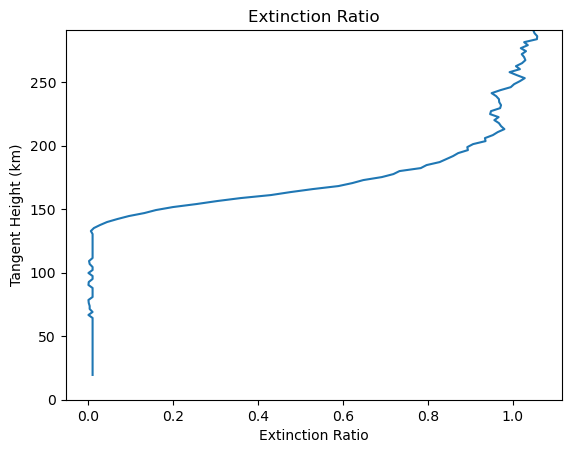

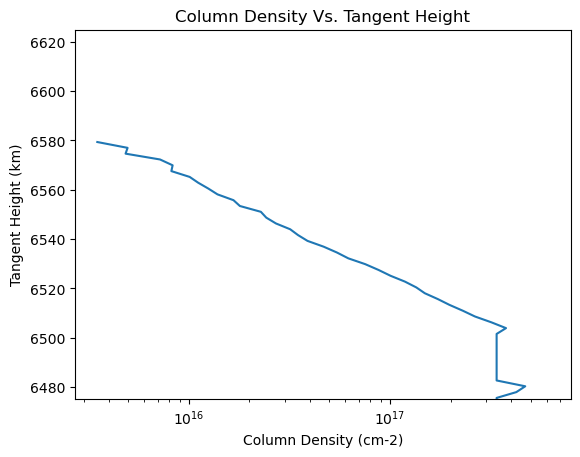

In [13]:
get_cd(files[3])

In [196]:

def smooth_cd(file):
    r_h = np.arange(6490, 6572, 1)
    ds = nc.Dataset(file)
    irradiance = ds.variables['irradiance'][5:]
    tan_ht = ds.variables['tanht'][5:]
    wavelength = ds.variables['wavelength'][5:]
    mjd = ds.variables['julian_date'][5:]
    lat = ds.variables['lat'][5:]
    lon = ds.variables['lon'][5:]
    columnDensity, tanht, time = get_cd(file)
    column_densityi = np.where(columnDensity > 0)
    column_density = columnDensity[column_densityi]
    tan_ht = tanht[column_densityi]
    interp_cd = interpolate.interp1d(tan_ht, np.log(column_density))
    new_cdlog = interp_cd(r_h - 6371)
    new_cd = np.exp(new_cdlog)
    smoothed_Cdensity = new_cd #becuase already smoothed the extinction ratio 
    # putting data into log space 
    log_of_Cdensity = np.log(smoothed_Cdensity)
    
    # only do fit for top 20 km
    top_20kmi = np.where(r_h > np.max(r_h) - 20)
    
    #use this scale 
    top_20km = r_h[top_20kmi] - 6422
    top_20cd = log_of_Cdensity[top_20kmi]
    log_fit = np.polyfit(top_20km, top_20cd, 1)
    fit = np.exp(log_fit)
    
    # this is the equation: y = aexp(cx)
    # this is the equation: ln(y) = ln(a) + cx
    #I need fit[a] and log_fit[c] becuase I took the log of the data so that means now i have c and log a
    a = fit[1]
    c = log_fit[0]
    
    # x is top_20km
    new_height = np.arange(150, 201, 1)
    height_fit = a*np.exp(c*new_height)
    
    # for now cut off new_cd
    alt_maxhf = max(height_fit)
    rHi = np.where(smoothed_Cdensity > alt_maxhf)
    rH = r_h[rHi]
    sm_cd1 = smoothed_Cdensity[rHi]
    
    updated_cd = np.concatenate((sm_cd1, height_fit))
    height = np.concatenate((rH, new_height + 6422))
    plt.plot(updated_cd, height, color = 'orange', label="Column Density with Extrapolated Fit")
    plt.xscale('log')
    plt.xlabel("Column Density (cm-2)")
    plt.ylabel("Tangent Height (km)")
    plt.title("Column Density (cm-2) vs. Tangent Height (km)")
    plt.legend(loc="upper right")
    plt.savefig("C:\\Users\\ameli\\OneDrive\\Desktop" + os.path.basename(file) + ".png")
    return height, updated_cd, r_h, smoothed_Cdensity

In [197]:
def irradiance(file):
    ds = nc.Dataset(file)
    irradiance = ds.variables['irradiance'][5:]
    tan_ht = ds.variables['tanht'][5:]
    wavelength = ds.variables['wavelength'][5:]
    mjd = ds.variables['julian_date'][5:]
    lat = ds.variables['lat'][5:]
    lon = ds.variables['lon'][5:]
    dt = []
    for i in mjd:
        date_time = julian.from_jd(i, fmt='jd')
        dt.append(date_time)
    plt.figure()
    plt.plot(dt, irradiance)
    plt.xticks(rotation = 45)
    plt.xlabel("Time (min)")
    plt.ylabel("Irradiance (photons/s/m2)")
    plt.title("Time vs. Irradiance")
    plt.savefig("C:\\Users\\ameli\\OneDrive\\Desktop" + os.path.basename(file) + ".png")

In [198]:
def updated_numberdensity(file):
    # first use the fit altitudes to get a number density, then cut them off--> resample with original array
    ds = nc.Dataset(file)
    irradiance = ds.variables['irradiance'][:]
    tan_ht = ds.variables['tanht'][::-1]
    mjd = ds.variables['julian_date'][:]
    lat = ds.variables['lat'][5:]
    lon = ds.variables['lon'][5:]
    time = []
    for i in mjd:
        date_time = julian.from_jd(i, fmt='jd')
        time.append(date_time)
    print('min', min(time))
    print('max', max(time))
    Height, updatedCd, Rh, smoothedCdensity = smooth_cd(file) 
    plt.figure()
    
    r_i = Height[:]
    # interpolate column density over new r_h when have a bigger array so that demesions of matrix line up 
    # an array that starts with 4 and stops with 5, so really stops on 4-- needs four columns and five rows 
    l_hi = np.zeros([len(Height), len(r_i)-1], dtype = np.double) # idl is column, row - so python is row, column this is just 0s with the dimensions of the two arrays
    l_hi[:] = -1 # makes all elements -1
    for h in range(Height.size): # populate this array with r_h and r_i 
        for i in range(r_i.size - 1):
            l_hi[h, i] = (np.sqrt(r_i[i + 1]**2 - Height[h]**2) - np.sqrt(r_i[i]**2 - Height[h]**2)) * 1e5
            if r_i[i] < Height[h]:
                l_hi[h, i] = 0
            if np.isnan(l_hi[h, i]):
                raise("invalid value")
    interpCd = interpolate.interp1d(Height, updatedCd) #tan_ht1
    Cd_150 = interpCd(150 + 6371)
    transp_L = l_hi.transpose()
    transp_L
    first = np.linalg.inv(np.matmul(transp_L, l_hi))
    first = np.matmul(first, transp_L)
    Number_density = np.matmul(first, updatedCd)
    fnumber_densityi = np.where(Number_density > 0)
    r_h1 = Height[fnumber_densityi]
    fnumber_density = Number_density[fnumber_densityi]
    interpNd = interpolate.interp1d(r_h1, fnumber_density)
    # now resample to original array 
    real_datai = np.where(r_h1 <= max(Rh))
    realh_data = fnumber_density[real_datai]
    Rh = Rh[real_datai]
    interp_Nd = interpolate.interp1d(Rh, realh_data)  
    Nd150 = interp_Nd(150 + 6371)
    Nd120 = interp_Nd(120 + 6371)
    Nd180 = interp_Nd(180 + 6371)
    
    print(file, '120 km', Nd120, 'cm-3')
    print(file, '150 km', Nd150, 'cm-3')
    print(file, '180 km', Nd180, 'cm-3')
    plt.figure()
    plt.plot(realh_data, Rh)
    
    plt.xlabel("Number Density (cm-3)")
    plt.ylabel("Tangent Height (km)")
    plt.xscale("log")
    plt.title("Number Density vs. Tangent Height")
    plt.savefig("C:\\Users\\ameli\\OneDrive\\Desktop" + os.path.basename(file) + ".png")
    return Nd150, Nd120, Nd180